In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [6]:
!ls ../data

budapest_connectome_3.0_209_0_median.graphml
budapest_connectome_3.0_209_0_median_20k.csv
budapest_connectome_3.0_209_0_median_fc_20k.csv
budapest_connectome_3.0_238_0_median_1m.csv
budapest_connectome_3.0_238_0_median_fc_1m.csv
budapest_connectome_3.0_239_0_median_200k.csv
budapest_connectome_3.0_239_0_median_fc_200k.csv


In [13]:
# Load the data from the provided CSV file
# current_dir = 
count_file_path = f'data/budapest_connectome_3.0_209_0_median_fc.csv'
length_file_path = f'data/budapest_connectome_3.0_209_0_median.csv'

df_count = pd.read_csv(count_file_path, delimiter=';')
df_len = pd.read_csv(length_file_path, delimiter=';')

In [14]:
df_count.head()

,id node1,id node2,name node1,name node2,parent id node1,parent id node2,parent name node1,parent name node2,edge confidence,edge weight(med nof)
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,25.0
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,5.0
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,8.0
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,6.0
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,3.0


In [15]:
df_len.head()

,id node1,id node2,name node1,name node2,parent id node1,parent id node2,parent name node1,parent name node2,edge confidence,edge weight(med flm)
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011


In [18]:
df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})
df_merged.head()

,node1,node2,fiber_count,fiber_length
0,9,37,25.0,22.239342
1,9,37,25.0,26.385718
2,9,37,25.0,36.416003
3,9,37,25.0,32.376669
4,9,37,25.0,27.144929


In [19]:
l = df_merged["node1"].astype('int')
max(l)

83

In [20]:
# Extract the necessary information
nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
num_nodes = len(nodes)
edges = list(zip(df_merged['node1'], df_merged['node2']))

print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

# nodes:76, # edges:11288


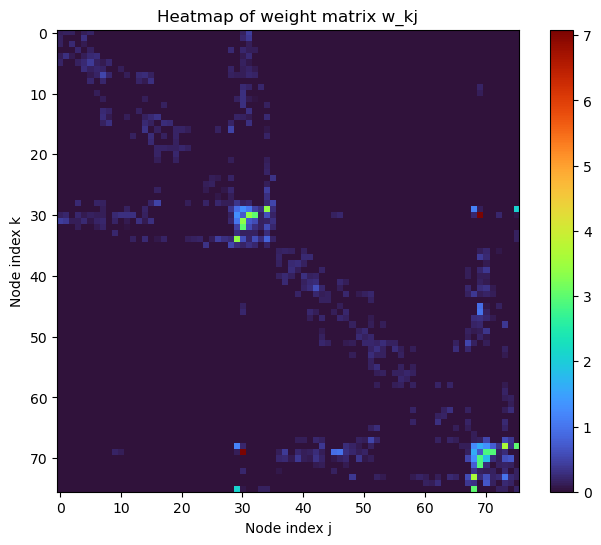

In [22]:
# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

w_kj = np.zeros((num_nodes, num_nodes))
        

for _, row in df_merged.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]
    weight = row['fiber_count']/row['fiber_length']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [2]:
def plot_connectivity(count_file_path, length_file_path):
    df_count = pd.read_csv(count_file_path, delimiter=';')
    df_len = pd.read_csv(length_file_path, delimiter=';')

    df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

    df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
    df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})

    l = df_merged["node1"].astype('int')
    print(f"Max node id{max(l)}")

    # Extract the necessary information
    nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
    num_nodes = len(nodes)
    edges = list(zip(df_merged['node1'], df_merged['node2']))

    print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

    # Create a mapping from node ID to index
    node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

    w_kj = np.zeros((num_nodes, num_nodes))
            

    for _, row in df_merged.iterrows():
        idx1 = node_to_index[row['node1']]
        idx2 = node_to_index[row['node2']]
        weight = row['fiber_count']/row['fiber_length']
        w_kj[idx1, idx2] = weight
        w_kj[idx2, idx1] = weight

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(w_kj, cmap='turbo')
    plt.colorbar(heatmap)
    plt.title('Heatmap of weight matrix w_kj')
    plt.xlabel('Node index j')
    plt.ylabel('Node index k')
    plt.show()

## Varying fibres launched

Max node id83
# nodes:76, # edges:11288


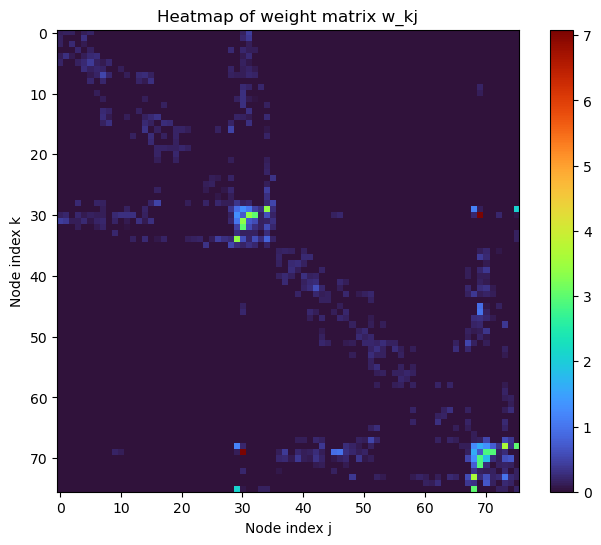

Max node id83
# nodes:81, # edges:154121


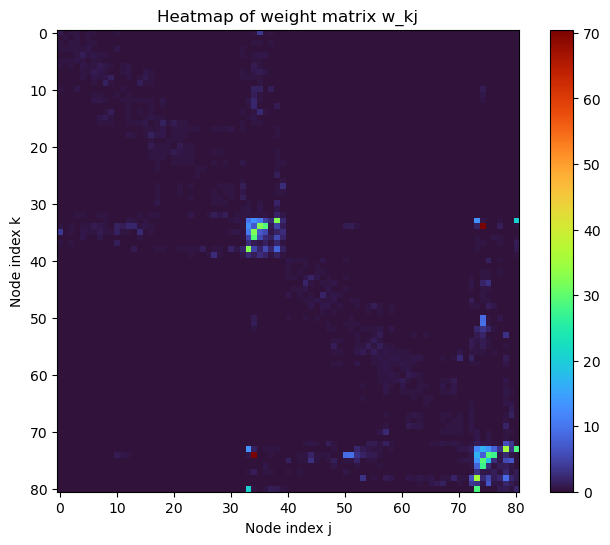

Max node id83
# nodes:81, # edges:404771


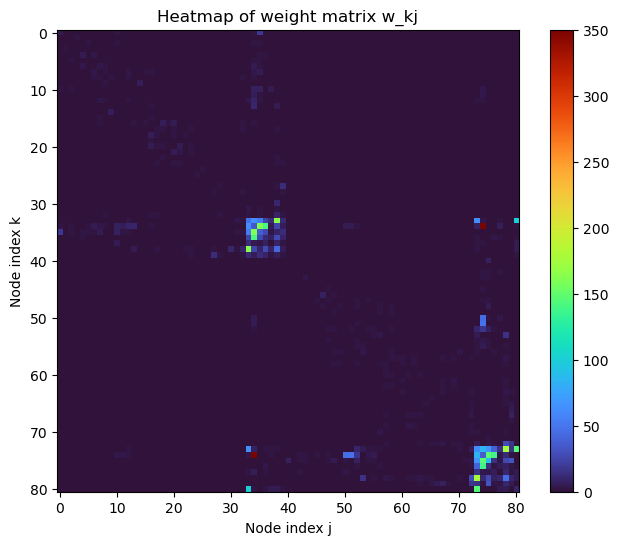

In [9]:
fibres_launched = {'20k': 209, '200k': 239, '1m': 238}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## varying edge confidence

Max node id83
# nodes:76, # edges:11288


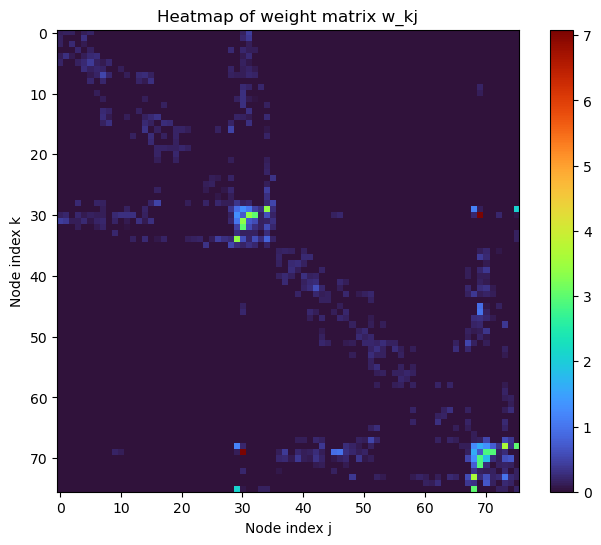

Max node id83
# nodes:78, # edges:28154


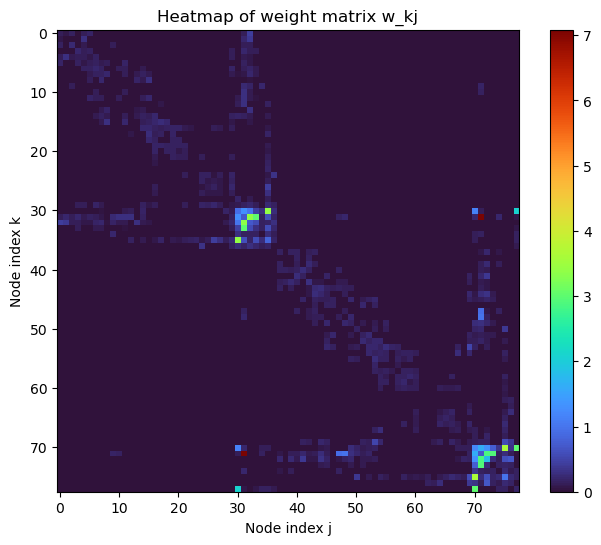

Max node id83
# nodes:83, # edges:5592725


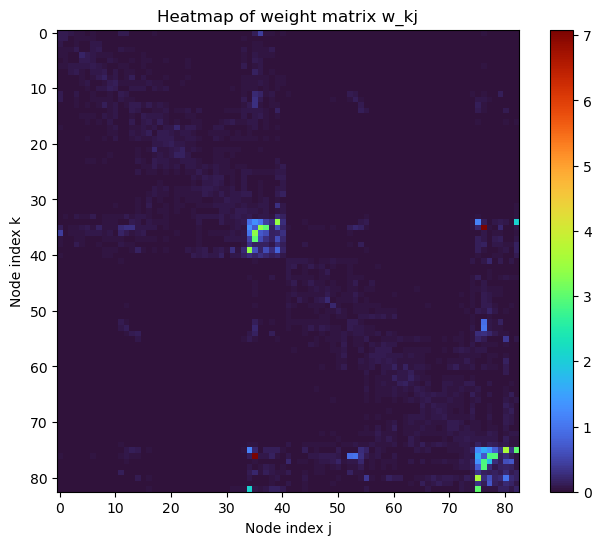

In [11]:
fibres_launched = {'20k': 209, '20k_40': 168, '20k_1':5}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## Varying edge weight

Max node id83
# nodes:83, # edges:5592725


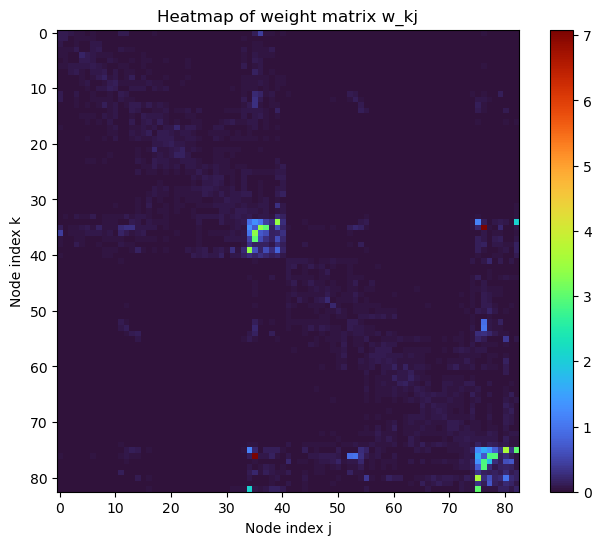

In [13]:
fibres_launched = {'20k_1':0.148}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_5_{value}_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_5_{value}_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## Resting state dynamics

In [6]:
! ls data

budapest_connectome_3.0_209_0_median.csv
budapest_connectome_3.0_209_0_median.graphml
graph_data_1.csv
graph_data_ec.csv
graph_data_ec_1.csv
graph_data_ec_2.csv
graph_data_fc.csv


In [4]:
file_path = f'../data/budapest_connectome_3.0_209_0_median.csv'
data = pd.read_csv(file_path, delimiter=';').rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med flm)':'fiber_length'})
data.head()

,id node1,id node2,name node1,name node2,node1,node2,parent name node1,parent name node2,edge confidence,fiber_length
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011


In [5]:
# Extract the necessary information
nodes = np.union1d(data['node1'].values, data['node2'].values)
num_nodes = len(nodes)
edges = list(zip(data['node1'], data['node2']))
print(num_nodes, len(edges))

w_kj = np.zeros((num_nodes, num_nodes))

# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

for _, row in data.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]
    weight = row['fiber_length']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

76 1000


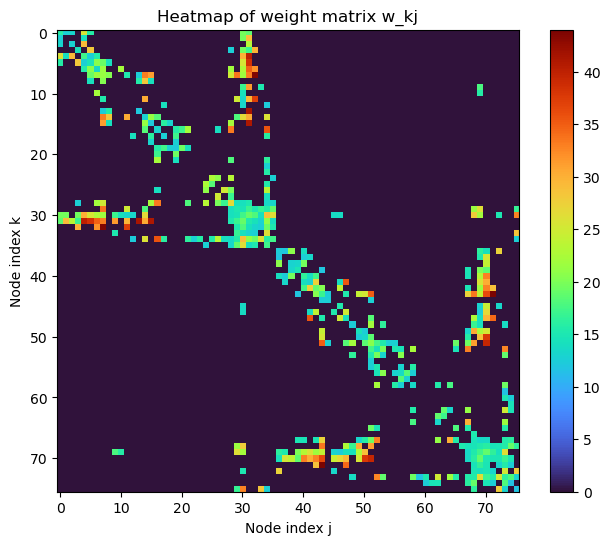

In [6]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

<Axes: xlabel='delay', ylabel='Density'>

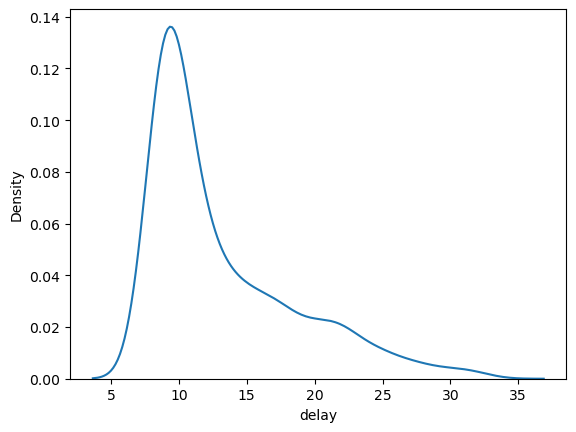

In [12]:
data['delay'] = data['fiber_length'] / 1.5
sns.kdeplot(data, x="delay")

In [14]:
data['delay_discrete'] = pd.cut(data['delay'], bins=40, labels=False)
data.head()

,id node1,id node2,name node1,name node2,node1,node2,parent name node1,parent name node2,edge confidence,fiber_length,delay,delay_discrete
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342,14.826228,11
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002,12.266668,7
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001,12.266667,7
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008,11.600005,6
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011,14.666674,11
